## Multisensory modulation (Fig 6)
This code examines how single neurons were modulated by multisensory information compared to unimodal information.

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
# Make sure you change "mother_path" properly to run this code
mother_path = Path('C:/multimodal-object-recognition-PER/')

fig_path = mother_path / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [5]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [6]:
# load results from ANOVA
data_path = mother_path /'result'/'ANOVA'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')

# load results from multiple linear regression
data2_path = mother_path /'result'/'multiple linear regression'/'2023-07-10'
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [7]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [8]:
df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['selectivity index']
      
    # load beta coefficients and multisensory modulation index
    if f[key].attrs['preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'pref_MV_mod'] = f[f'{key}/multi_cohend'][0]
        df.loc[df['key']==key,'pref_MA_mod'] = f[f'{key}/multi_cohend'][1]
        
        df.loc[df['key']==key,'nonpref_MV_mod'] = f[f'{key}/multi_cohend'][2]
        df.loc[df['key']==key,'nonpref_MA_mod'] = f[f'{key}/multi_cohend'][3]        
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'pref_MV_mod'] = f[f'{key}/multi_cohend'][2]
        df.loc[df['key']==key,'pref_MA_mod'] = f[f'{key}/multi_cohend'][3]
        
        df.loc[df['key']==key,'nonpref_MV_mod'] = f[f'{key}/multi_cohend'][0]
        df.loc[df['key']==key,'nonpref_MA_mod'] = f[f'{key}/multi_cohend'][1]      
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:    # sample first half
        df.loc[i,'peak_selectivity_time_range2'] = 0    
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:    # sample second half
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:    # response first half
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:    # response second half
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Classifying visual, auditory, and crossmodal neurons

In [10]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'crossmodal'

In [11]:
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='crossmodal')]

print('The number of neurons in each category')
print('=======================================')
print(f'Visual cell: {x[0]} / {np.sum(x)}')
print(f'Auditory cell: {x[1]} / {np.sum(x)}')
print(f'Crossmodal cell: {x[2]} / {np.sum(x)}')

The number of neurons in each category
Visual cell: 21 / 149
Auditory cell: 27 / 149
Crossmodal cell: 101 / 149


## Examining Rate Modulation Index (RMI)

### Rate modulation indices (VA-V and VA-A)

#### Visual and auditory cells

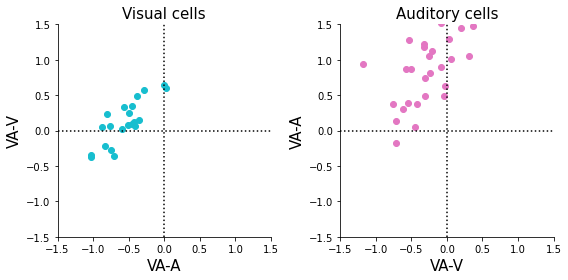

In [13]:
fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].scatter(df.loc[df['Category']=='visual','pref_MV_mod'], 
              df.loc[df['Category']=='visual','pref_MA_mod'], color='tab:cyan')
ax[0].axhline(y=0, color='black', linestyle=':')
ax[0].axvline(x=0, color='black', linestyle=':')
ax[0].set_xlim([-1.5, 1.5]);
ax[0].set_xticks(np.arange(-1.5, 1.6, 0.5));
ax[0].set_ylim([-1.5, 1.5]);
ax[0].set_yticks(np.arange(-1.5, 1.6, 0.5));
ax[0].set_xlabel('VA-A', fontsize=15)
ax[0].set_ylabel('VA-V', fontsize=15)
ax[0].set_title('Visual cells', fontsize=15)

#x1 = df.loc[df['Category']=='visual','pref_MV_mod'].mean()
#sem1 = df.loc[df['Category']=='visual','pref_MV_mod'].sem()
#x2 = df.loc[df['Category']=='visual','pref_MA_mod'].mean()
#sem2 = df.loc[df['Category']=='visual','pref_MA_mod'].sem()
#ax[0].errorbar(x1, x2, xerr=sem1, yerr=sem2, fmt='s')

ax[1].scatter(df.loc[df['Category']=='auditory','pref_MA_mod'],
              df.loc[df['Category']=='auditory','pref_MV_mod'], color='tab:pink')
ax[1].axhline(y=0, color='black', linestyle=':')
ax[1].axvline(x=0, color='black', linestyle=':')
ax[1].set_xlim([-1.5, 1.5]);
ax[1].set_xticks(np.arange(-1.5, 1.6, 0.5));
ax[1].set_ylim([-1.5, 1.5]);
ax[1].set_yticks(np.arange(-1.5, 1.6, 0.5));
ax[1].set_xlabel('VA-V', fontsize=15)
ax[1].set_ylabel('VA-A', fontsize=15)
ax[1].set_title('Auditory cells', fontsize=15)

#x1 = df.loc[df['Category']=='auditory','pref_MA_mod'].mean()
#sem1 = df.loc[df['Category']=='auditory','pref_MA_mod'].sem()
#x2 = df.loc[df['Category']=='auditory','pref_MV_mod'].mean()
#sem2 = df.loc[df['Category']=='auditory','pref_MV_mod'].sem()
#ax[1].errorbar(x1, x2, xerr=sem1, yerr=sem2, fmt='s')

plt.tight_layout()

#plt.savefig(fig_path / 'svg' / 'VA-V_VA_A_index_scatter.svg')

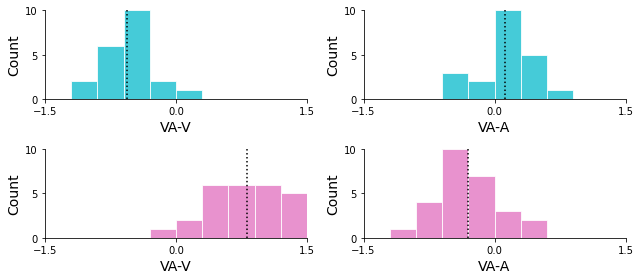

In [51]:
fig,ax = plt.subplots(2,2,figsize=(9,4))

x = ['pref_MV_mod', 'pref_MA_mod']
xlabel = ['VA-V', 'VA-A']

for i in range(2):
    ax[0,i].hist(df.loc[df['Category']=='visual',x[i]], color='tab:cyan', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[0,i].axvline(x=df.loc[df['Category']=='visual',x[i]].mean(),color='black',linestyle=':')
    ax[0,i].set_xlabel(xlabel[i], fontsize=14);
    ax[0,i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[0,i].set_xlim([-1.5,1.5])
    ax[0,i].set_ylabel('Count', fontsize=14);
    #ax[0,i].set_yticks(np.arange(0,45,10));
    ax[0,i].set_ylim([0,10])
    ax[0,i].set_yticks([0,5,10])
    
    ax[1,i].hist(df.loc[df['Category']=='auditory',x[i]], color='tab:pink', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[1,i].axvline(x=df.loc[df['Category']=='auditory',x[i]].mean(),color='black',linestyle=':')
    ax[1,i].set_xlabel(xlabel[i], fontsize=14);
    ax[1,i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[1,i].set_xlim([-1.5,1.5])
    ax[1,i].set_ylabel('Count', fontsize=14);
    ax[1,i].set_ylim([0,10])
    ax[1,i].set_yticks([0,5,10])
    
plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_hist.svg')

In [19]:
print('Visual cells')
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='visual','pref_MV_mod'], y = 0))
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='visual','pref_MA_mod'], y = 0))

print('===================================================================')
print('Auditory cells')
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='auditory','pref_MA_mod'], y = 0))
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='auditory','pref_MV_mod'], y = 0))

Visual cells
VA-V
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.904344   20   two-sided  2.144607e-08  [-0.69, -0.43]  1.943087   

             BF10  power  
T-test  6.219e+05    1.0  
VA-A
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.776517   20   two-sided  0.090863  [-0.02, 0.26]  0.387668  0.863   

           power  
T-test  0.394215  
Auditory cells
VA-A
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -4.476013   26   two-sided  0.000134  [-0.45, -0.17]  0.861409   

           BF10     power  
T-test  203.629  0.990496  
VA-V
               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  9.181568   26   two-sided  1.216453e-09  [0.63, 0.99]  1.766993   

             BF10  power  
T-test  9.359e+06    1.0  


#### Crossmodal cells

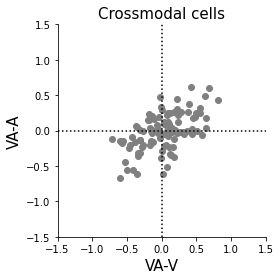

In [18]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(df.loc[df['Category']=='crossmodal','pref_MV_mod'], 
              df.loc[df['Category']=='crossmodal','pref_MA_mod'], color='gray')
ax.axhline(y=0, color='black', linestyle=':')
ax.axvline(x=0, color='black', linestyle=':')
ax.set_xlim([-1.5, 1.5]);
ax.set_xticks(np.arange(-1.5, 1.6, 0.5));
ax.set_ylim([-1.5, 1.5]);
ax.set_yticks(np.arange(-1.5, 1.6, 0.5));
ax.set_xlabel('VA-V', fontsize=15)
ax.set_ylabel('VA-A', fontsize=15)
ax.set_title('Crossmodal cells', fontsize=15)

plt.tight_layout()

plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_crossmodal_scatter.svg')

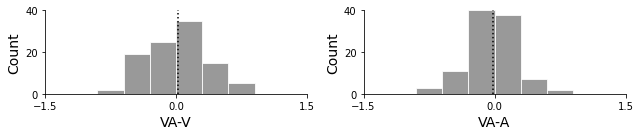

Crossmodal cells
VA-V
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.695386  100   two-sided  0.488427  [-0.04, 0.09]  0.069193  0.139   

           power  
T-test  0.105862  
VA-A
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.494462  100   two-sided  0.622065  [-0.06, 0.04]  0.049201  0.124   

           power  
T-test  0.077898  


In [17]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['pref_MV_mod', 'pref_MA_mod']
xlabel = ['VA-V', 'VA-A']

for i in range(2):
    ax[i].hist(df.loc[df['Category']=='crossmodal',x[i]], color='gray', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[i].axvline(x=df.loc[df['Category']=='crossmodal',x[i]].mean(),color='black',linestyle=':')
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[i].set_xlim([-1.5,1.5])
    ax[i].set_ylabel('Count', fontsize=14);
    #ax[0,i].set_yticks(np.arange(0,45,10));
    ax[i].set_ylim([0,40])
    ax[i].set_yticks(np.arange(0,41,20))

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_crossmodal_hist.svg')
plt.show()

print('Crossmodal cells')
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='crossmodal','pref_MV_mod'], y = 0))
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='crossmodal','pref_MA_mod'], y = 0))